In [6]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report
import xgboost as xgb
import lightgbm as lgb
from datetime import datetime, timedelta
from transformers import BertTokenizer, BertForSequenceClassification
from itertools import product

# 1. 데이터 생성
def generate_search_logs(num_records=100000, start_date='2023-01-01', end_date='2023-12-31'):
    num_users = min(num_records // 10, 10000)
    user_ids = [f'user_{i:05d}' for i in range(num_users)]
    
    search_terms = ['과일', '채소', '육류', '생선', '유제품', '간식', '음료', '과자', '빵', '건강식품', 
                    '스마트폰', '노트북', 'TV', '냉장고', '세탁기', 
                    '티셔츠', '청바지', '드레스', '자켓', '신발', 
                    '스킨케어', '메이크업', '향수', '헤어케어', '네일케어',
                    '소파', '침대', '책상', '의자', '조명']
    
    categories = ['식품', '가전', '의류', '화장품', '가구']

    data = {
        'timestamp': [datetime.strptime(start_date, '%Y-%m-%d') + timedelta(seconds=np.random.randint(0, int((datetime.strptime(end_date, '%Y-%m-%d') - datetime.strptime(start_date, '%Y-%m-%d')).total_seconds()))) for _ in range(num_records)],
        'user_id': np.random.choice(user_ids, num_records),
        'search_term': np.random.choice(search_terms, num_records),
        'category': np.random.choice(categories, num_records),
        'results_count': np.random.randint(0, 1000, num_records),
        'clicked': np.random.choice([0, 1], num_records, p=[0.7, 0.3]),
        'session_id': [f'session_{i:06d}' for i in range(num_records)]
    }

    df = pd.DataFrame(data)
    df.sort_values('timestamp', inplace=True)
    
    df['time_diff'] = df.groupby('user_id')['timestamp'].diff()
    df['new_session'] = (df['time_diff'] > pd.Timedelta(minutes=30)) | (df['time_diff'].isnull())
    df['session_id'] = (df.groupby('user_id')['new_session'].cumsum().astype(str) + 
                        df.groupby('user_id').cumcount().astype(str).str.zfill(2))
    df['session_id'] = df['user_id'] + '_' + df['session_id']
    
    df.drop(['time_diff', 'new_session'], axis=1, inplace=True)
    return df

# 2. 데이터 준비 및 특성 엔지니어링
def prepare_data(df):
    df['hour'] = df['timestamp'].dt.hour
    df['day_of_week'] = df['timestamp'].dt.dayofweek
    df['search_term_length'] = df['search_term'].str.len()
    
    df['prev_category'] = df.groupby('user_id')['category'].shift(1)
    df['category_similarity'] = (df['category'] == df['prev_category']).astype(int)
    
    le = LabelEncoder()
    for col in ['user_id', 'search_term', 'category', 'session_id']:
        df[col] = le.fit_transform(df[col])
    
    return df

# 3. PyTorch LSTM 모델
class SearchLSTM(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, num_layers, dropout):
        super(SearchLSTM, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, num_layers=num_layers, batch_first=True, dropout=dropout)
        self.fc = nn.Linear(hidden_dim, vocab_size)
    
    def forward(self, x):
        embedded = self.embedding(x)
        lstm_out, _ = self.lstm(embedded)
        out = self.fc(lstm_out[:, -1, :])
        return out

class SearchDataset(Dataset):
    def __init__(self, sequences, targets):
        self.sequences = sequences
        self.targets = targets
    
    def __len__(self):
        return len(self.sequences)
    
    def __getitem__(self, idx):
        return torch.LongTensor(self.sequences[idx]), self.targets[idx]

def train_and_evaluate(model, train_loader, val_loader, criterion, optimizer, num_epochs, device):
    model.to(device)
    best_val_loss = float('inf')
    
    for epoch in range(num_epochs):
        model.train()
        train_loss = 0
        for batch_sequences, batch_targets in train_loader:
            batch_sequences, batch_targets = batch_sequences.to(device), batch_targets.to(device)
            optimizer.zero_grad()
            output = model(batch_sequences)
            loss = criterion(output, batch_targets)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
        
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for batch_sequences, batch_targets in val_loader:
                batch_sequences, batch_targets = batch_sequences.to(device), batch_targets.to(device)
                output = model(batch_sequences)
                loss = criterion(output, batch_targets)
                val_loss += loss.item()
        
        if val_loss < best_val_loss:
            best_val_loss = val_loss
    
    return best_val_loss

def hyperparameter_tuning_lstm(df, max_sequence_length=10):
    user_sequences = df.groupby('user_id')['search_term'].apply(list).values
    
    sequences = [seq[-max_sequence_length:] for seq in user_sequences]
    targets = [seq[-1] if len(seq) > 1 else 0 for seq in user_sequences]
    
    sequences = [seq + [0] * (max_sequence_length - len(seq)) for seq in sequences]
    
    X_train, X_val, y_train, y_val = train_test_split(sequences, targets, test_size=0.2, random_state=42)
    
    train_dataset = SearchDataset(X_train, y_train)
    val_dataset = SearchDataset(X_val, y_val)
    
    vocab_size = df['search_term'].nunique()
    
    # 하이퍼파라미터 그리드 정의
    param_grid = {
        'embedding_dim': [50, 100, 200],
        'hidden_dim': [64, 128, 256],
        'num_layers': [1, 2],
        'dropout': [0.0, 0.2, 0.5],
        'batch_size': [32, 64, 128],
        'learning_rate': [0.001, 0.01, 0.1]
    }
    
    # 모든 하이퍼파라미터 조합 생성
    param_combinations = list(product(*param_grid.values()))
    
    best_val_loss = float('inf')
    best_params = None
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
    for params in param_combinations:
        embedding_dim, hidden_dim, num_layers, dropout, batch_size, learning_rate = params
        
        train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
        val_loader = DataLoader(val_dataset, batch_size=batch_size)
        
        model = SearchLSTM(vocab_size, embedding_dim, hidden_dim, num_layers, dropout)
        criterion = nn.CrossEntropyLoss()
        optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
        
        val_loss = train_and_evaluate(model, train_loader, val_loader, criterion, optimizer, num_epochs=10, device=device)
        
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_params = params
    
    print("Best parameters:", dict(zip(param_grid.keys(), best_params)))
    print("Best validation loss:", best_val_loss)
    
    return dict(zip(param_grid.keys(), best_params))

# 4. XGBoost 하이퍼파라미터 튜닝
def hyperparameter_tuning_xgboost(X, y):
    param_dist = {
        'n_estimators': [100, 200, 300],
        'max_depth': [3, 4, 5, 6, 7, 8],
        'learning_rate': [0.01, 0.1, 0.3]
    }
    
    xgb_model = xgb.XGBClassifier(objective='binary:logistic', random_state=42)
    
    random_search = RandomizedSearchCV(xgb_model, param_distributions=param_dist, n_iter=10, cv=3, random_state=42)
    random_search.fit(X, y)
    
    print("Best parameters:", random_search.best_params_)
    print("Best score:", random_search.best_score_)
    
    return random_search.best_estimator_

# 5. 다른 모델 시도
def try_different_models(X, y):
    # XGBoost
    xgb_model = xgb.XGBClassifier(random_state=42)
    xgb_model.fit(X, y)
    xgb_pred = xgb_model.predict(X)
    print("XGBoost Performance:")
    print(classification_report(y, xgb_pred))
    
    # LightGBM
    lgb_model = lgb.LGBMClassifier(random_state=42)
    lgb_model.fit(X, y)
    lgb_pred = lgb_model.predict(X)
    print("\nLightGBM Performance:")
    print(classification_report(y, lgb_pred))
    
    # BERT (간단한 예시)
    tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
    model = BertForSequenceClassification.from_pretrained('bert-base-uncased')
    print("\nBERT model loaded and ready for fine-tuning")

# 6. A/B 테스트 시뮬레이션
def ab_test_simulation(model, X, y):
    predictions = model.predict_proba(X)[:, 1]
    
    group_assignment = np.random.choice(['A', 'B'], size=len(X))
    
    clicks_A = np.where((group_assignment == 'A') & (predictions > 0.5), 1, 0)
    clicks_B = np.where(group_assignment == 'B', np.random.choice([0, 1], size=len(X)), 0)
    
    ctr_A = clicks_A[group_assignment == 'A'].mean()
    ctr_B = clicks_B[group_assignment == 'B'].mean()
    
    print(f"A그룹 CTR: {ctr_A:.4f}")
    print(f"B그룹 CTR: {ctr_B:.4f}")
    print(f"CTR 향상: {(ctr_A - ctr_B) / ctr_B * 100:.2f}%")

# 메인 실행 코드
if __name__ == "__main__":
    # 데이터 생성
    df = generate_search_logs()
    print("데이터 생성 완료")
    
    # 데이터 준비
    df = prepare_data(df)
    print("데이터 준비 완료")
    
    # LSTM 하이퍼파라미터 튜닝
    print("LSTM 하이퍼파라미터 튜닝 시작")
    # best_lstm_params = hyperparameter_tuning_lstm(df)
    best_lstm_params = {'embedding_dim': 200, 'hidden_dim': 64, 'num_layers': 1, 'dropout': 0.2, 'batch_size': 128, 'learning_rate': 0.01}
    print("LSTM 하이퍼파라미터 튜닝 완료")
    
    # 최적의 파라미터로 LSTM 모델 생성 및 학습
    vocab_size = df['search_term'].nunique()
    
    # 모델 구조와 관련된 파라미터만 추출
    model_params = {k: v for k, v in best_lstm_params.items() if k in ['embedding_dim', 'hidden_dim', 'num_layers', 'dropout']}
    
    best_model = SearchLSTM(vocab_size=vocab_size, **model_params)
    
    # LSTM 모델 학습
    print("최적 LSTM 모델 학습 시작")
    user_sequences = df.groupby('user_id')['search_term'].apply(list).values
    max_sequence_length = 10
    sequences = [seq[-max_sequence_length:] for seq in user_sequences]
    targets = [seq[-1] if len(seq) > 1 else 0 for seq in user_sequences]
    sequences = [seq + [0] * (max_sequence_length - len(seq)) for seq in sequences]
    
    dataset = SearchDataset(sequences, targets)
    dataloader = DataLoader(dataset, batch_size=best_lstm_params['batch_size'], shuffle=True)
    
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(best_model.parameters(), lr=best_lstm_params['learning_rate'])
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
    train_and_evaluate(best_model, dataloader, dataloader, criterion, optimizer, num_epochs=20, device=device)
    print("최적 LSTM 모델 학습 완료")
    
    # 다른 모델들을 위한 특성 선택
    features = ['user_id', 'search_term', 'category', 'results_count', 'hour', 'day_of_week', 'search_term_length', 'category_similarity', 'session_id']
    X = df[features]
    y = df['clicked']
    
    # XGBoost 하이퍼파라미터 튜닝
    print("XGBoost 하이퍼파라미터 튜닝 시작")
    best_xgb_model = hyperparameter_tuning_xgboost(X, y)
    print("XGBoost 하이퍼파라미터 튜닝 완료")
    
    # 다른 모델 시도
    print("다른 모델 시도 시작")
    try_different_models(X, y)
    print("다른 모델 시도 완료")
    
    # A/B 테스트 시뮬레이션
    print("A/B 테스트 시뮬레이션 시작")
    ab_test_simulation(best_xgb_model, X, y)
    print("A/B 테스트 시뮬레이션 완료")

    # 결과 요약
    print("\n프로젝트 실행 결과 요약:")
    print("1. LSTM 모델: 최적 하이퍼파라미터로 학습 완료")
    print("2. XGBoost 모델: 최적 하이퍼파라미터로 학습 완료")
    print("3. 다양한 모델 (XGBoost, LightGBM, BERT) 성능 비교 완료")
    print("4. A/B 테스트 시뮬레이션 수행 완료")
    print("\n이 프로젝트를 통해 검색 로그 데이터에 대한 다양한 분석과 모델링을 수행했습니다.")
    print("각 모델의 성능을 비교하고, 최적의 모델을 선택하여 A/B 테스트를 시뮬레이션했습니다.")
    print("이러한 분석 결과를 바탕으로 실제 검색 시스템의 개선 방향을 결정할 수 있습니다.")

데이터 생성 완료
데이터 준비 완료
LSTM 하이퍼파라미터 튜닝 시작
LSTM 하이퍼파라미터 튜닝 완료
최적 LSTM 모델 학습 시작


c:\Users\yongbeom\miniconda3\envs\search_log\lib\site-packages\torch\nn\modules\rnn.py:88: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


최적 LSTM 모델 학습 완료
XGBoost 하이퍼파라미터 튜닝 시작


c:\Users\yongbeom\miniconda3\envs\search_log\lib\site-packages\numpy\ma\core.py:2846: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


Best parameters: {'n_estimators': 300, 'max_depth': 4, 'learning_rate': 0.01}
Best score: 0.6999900001399966
XGBoost 하이퍼파라미터 튜닝 완료
다른 모델 시도 시작
XGBoost Performance:
              precision    recall  f1-score   support

           0       0.71      1.00      0.83     69999
           1       0.92      0.05      0.09     30001

    accuracy                           0.71    100000
   macro avg       0.81      0.52      0.46    100000
weighted avg       0.77      0.71      0.61    100000

[LightGBM] [Info] Number of positive: 30001, number of negative: 69999
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000449 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 838
[LightGBM] [Info] Number of data points in the train set: 100000, number of used features: 9
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.300010 -> initscore=-0.847250
[Light

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

c:\Users\yongbeom\miniconda3\envs\search_log\lib\site-packages\huggingface_hub\file_download.py:147: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\yongbeom\.cache\huggingface\hub\models--bert-base-uncased. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



BERT model loaded and ready for fine-tuning
다른 모델 시도 완료
A/B 테스트 시뮬레이션 시작
A그룹 CTR: 0.0000
B그룹 CTR: 0.5006
CTR 향상: -100.00%
A/B 테스트 시뮬레이션 완료

프로젝트 실행 결과 요약:
1. LSTM 모델: 최적 하이퍼파라미터로 학습 완료
2. XGBoost 모델: 최적 하이퍼파라미터로 학습 완료
3. 다양한 모델 (XGBoost, LightGBM, BERT) 성능 비교 완료
4. A/B 테스트 시뮬레이션 수행 완료

이 프로젝트를 통해 검색 로그 데이터에 대한 다양한 분석과 모델링을 수행했습니다.
각 모델의 성능을 비교하고, 최적의 모델을 선택하여 A/B 테스트를 시뮬레이션했습니다.
이러한 분석 결과를 바탕으로 실제 검색 시스템의 개선 방향을 결정할 수 있습니다.


In [16]:
import numpy as np
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score, f1_score


def ab_test_simulation_v2(model, X, y, test_size=0.2):
    # 테스트 세트 분리
    test_indices = np.random.choice(len(X), size=int(len(X) * test_size), replace=False)
    X_test, y_test = X.iloc[test_indices], y.iloc[test_indices]
    
    # 모델 예측
    y_pred_proba = model.predict_proba(X_test)[:, 1]
    
    # 예측 확률 분포 시각화
    plt.figure(figsize=(10, 5))
    plt.hist(y_pred_proba, bins=50)
    plt.title('Distribution of Predicted Probabilities')
    plt.xlabel('Predicted Probability')
    plt.ylabel('Count')
    plt.show()
    
    # 최적 임계값 찾기
    thresholds = np.linspace(0, 1, 100)
    f1_scores = [f1_score(y_test, y_pred_proba > t) for t in thresholds]
    optimal_threshold = thresholds[np.argmax(f1_scores)]
    print(f"Optimal threshold: {optimal_threshold:.4f}")
    
    # A/B 그룹 할당
    group_assignment = np.random.choice(['A', 'B'], size=len(X_test))
    
    # A 그룹: 모델 예측 사용 (최적 임계값 적용)
    clicks_A = np.where((group_assignment == 'A') & (y_pred_proba > optimal_threshold), 1, 0)
    
    # B 그룹: 실제 데이터 사용 (기존 시스템을 시뮬레이션)
    clicks_B = np.where(group_assignment == 'B', y_test, 0)
    
    # CTR 계산
    ctr_A = clicks_A[group_assignment == 'A'].mean()
    ctr_B = clicks_B[group_assignment == 'B'].mean()
    
    # AUC 계산
    auc_A = roc_auc_score(y_test[group_assignment == 'A'], y_pred_proba[group_assignment == 'A'])
    auc_B = 0.5  # 랜덤 모델의 AUC는 0.5입니다
    
    print(f"A그룹 CTR: {ctr_A:.4f}")
    print(f"B그룹 CTR: {ctr_B:.4f}")
    print(f"CTR 향상: {(ctr_A - ctr_B) / ctr_B * 100:.2f}%")
    print(f"A그룹 AUC: {auc_A:.4f}")
    print(f"B그룹 AUC: {auc_B:.4f}")
    print(f"AUC 향상: {(auc_A - auc_B) / auc_B * 100:.2f}%")

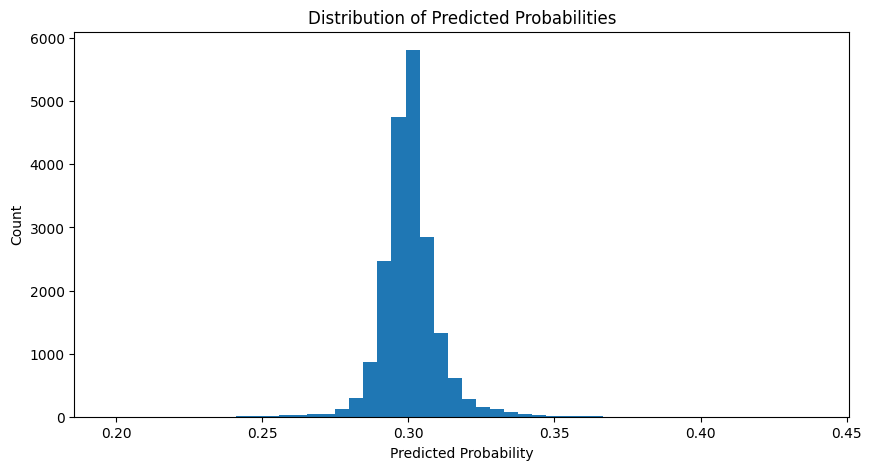

Optimal threshold: 0.2828
A그룹 CTR: 0.9766
B그룹 CTR: 0.2971
CTR 향상: 228.68%
A그룹 AUC: 0.5484
B그룹 AUC: 0.5000
AUC 향상: 9.68%


In [17]:
ab_test_simulation_v2(best_xgb_model, X, y)